<a href="https://colab.research.google.com/github/Abdullahaml1/stanford-cs224s/blob/main/homeworks/CS224S_Homework_1_Part_3_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Audio analysis toolkits

CS224S / LINGUIST285: Spoken Language Processing. Homework 1 Notebook.

In this homework we will use [Librosa](https://librosa.org/doc/latest/index.html) and [pysptk](http://sp-tk.sourceforge.net/). Both of these libraries have implementations of speech analysis and signal processing algorithms along with helper functions for data loading and visualization. You can find more documentation about each of these online ([Librosa docs](https://librosa.org/doc/latest/index.html), [pysptk github](https://github.com/r9y9/pysptk)).

We built this homework in Colab to make it easy to get set up and use these toolkits in a way you might use them when working with audio data on a new research/development project. However Colab is far from perfect for visualizing, labeling, and working with audio.

A widely used software tool for speech analysis is [Praat](https://www.fon.hum.uva.nl/praat/). You don't need to use it for this homework, but if you want to do similar analysis for your project consider using Praat directly. Here is a [tutorial on Praat](https://web.stanford.edu/dept/linguistics/corpora/material/PRAAT_workshop_manual_v421.pdf), and the [Parselmouth](https://parselmouth.readthedocs.io/en/stable/) library makes some features of Praat available in a pythonic way. You can also achieve some analysis and audio editing with the open source tool [Audacity](https://www.audacityteam.org/)

### Instructions

Throughout the notebook, there will be blocks labeled with **Task**, which have cells left open for your solutions. The tasks in this notebook make up 50 points of the overall 100 for Homework 1.

# Imports

Ensure you can run all of the imports below before you start work. Run these imports as part of your initial session each time. In this notebook we will use the library which has some specialized functions for working with audio.

In [2]:
!pip install pysptk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pysptk: filename=pysptk-0.2.1-cp310-cp310-linux_x86_64.whl size=1137268 sha256=a6329ba9813b1e1c4a2711ff30e0c4bce408bf0408de9796c74f402fc64fbdec
  Stored in directory: /root/.cache/pip/wheels/aa/96/e5/2348f6f568b9888d3505a97dc53287152ffd0440526cc6105d
Successfully built pysptk


In [3]:
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import matplotlib.pyplot as plt

# used to play audio files
import IPython.display as ipd
from base64 import b64decode


# Data preparation

Throughout this course, we will be working with a new speech dataset of conversations between bank employees and customers. In this homework, we will take our first glance at a handful of raw audio clips from the [HarperValleyBank dataset](https://arxiv.org/abs/2010.13929). Working with audio files in this way is similar to what you might experience when working with data exported from call center recordings or similar telephone/app-based human-human interactions.

To start, ensure you can execute the commands below to locate and load the audio files.

## Data loading

In [4]:
# download dataset from public GDrive
!gdown --id 1tFaTu7LWuCxn3DkAyudGGyv6eilVO5pC
#https://drive.google.com/file/d/1tFaTu7LWuCxn3DkAyudGGyv6eilVO5pC

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tFaTu7LWuCxn3DkAyudGGyv6eilVO5pC
To: /content/hvb_sampledata.zip
100% 1.78M/1.78M [00:00<00:00, 93.6MB/s]


In [5]:
!unzip -o hvb_sampledata.zip

Archive:  hvb_sampledata.zip
   creating: sample/
  inflating: sample/.DS_Store        
   creating: sample/agent/
   creating: sample/caller/
  inflating: sample/agent/ad97ae16985c4656.wav  
  inflating: sample/agent/29e0a36fb0c6401e.wav  
  inflating: sample/agent/0002f70f7386445b.wav  
  inflating: sample/agent/819176a5510d4563.wav  
  inflating: sample/agent/5614cbe304874883.wav  
  inflating: sample/caller/ad97ae16985c4656.wav  
  inflating: sample/caller/29e0a36fb0c6401e.wav  
  inflating: sample/caller/0002f70f7386445b.wav  
  inflating: sample/caller/819176a5510d4563.wav  
  inflating: sample/caller/5614cbe304874883.wav  


In [6]:
ls sample

agent/  caller/


In the `sample` folder, we've put a few example conversations between an agent (bank employee) and a caller (bank customer). Each conversation is split into two `.wav` files by speaker. For example, `sample/agent/0002f70f7386445b.wav` and `sample/caller/0002f70f7386445b.wav` belong to the same conversation. The first file contains everything the agent says while the second contains everything the caller says. This speaker-separated format is common in speech corpora.

In [7]:
ls sample/agent

0002f70f7386445b.wav  5614cbe304874883.wav  ad97ae16985c4656.wav
29e0a36fb0c6401e.wav  819176a5510d4563.wav


In [8]:
ls sample/caller

0002f70f7386445b.wav  5614cbe304874883.wav  ad97ae16985c4656.wav
29e0a36fb0c6401e.wav  819176a5510d4563.wav


## Playing audio files

We can listen to the audio files to familiarize ourselves with the data. The long pauses you hear between utterances is because each audio file is from only one side of the conversation.

In [9]:
# agent side of the conversation
ipd.Audio('./sample/agent/0002f70f7386445b.wav')

In [10]:
# caller side of the conversation
ipd.Audio('./sample/caller/0002f70f7386445b.wav')

## Loading audio into an array

When working with spoken language, we often want to visualize and process the raw audio before applying machine learning or signal processing approaches. To do this, we typically work with an audio file as an array or tensor. Our audio files are a single channel (mono, not stereo), or we sometimes have a two-party conversation encoded as stereo with one speaker in the left/right channel for separation.

The `librosa` package contains a suite of utilities to open and process waveforms. The function `librosa.load` loads an audio file as a floating point time series. It will return a numpy array containing samples from the audio clip and the sample rate (`sr`) listed in the audio file header. The sample rate is an integeter for how many samples (array indices) correspond to 1 second of realtime audio. The higher the sample rate, the higher the "resolution" of an audio clip.

In [11]:
# sr represents a "sample rate"
wav_agent, sr_agent = librosa.load('./sample/agent/0002f70f7386445b.wav')
wav_caller, sr_caller = librosa.load('./sample/caller/0002f70f7386445b.wav')

Like above, there are long pauses in each clip where the other speaker is speaking.  These "silence" gaps are intended to allow users to recover the original conversation if needed.

## **Task: Combine both conversation sides into a single array** (3 points)

To familiarize yourself with waveforms and `librosa`, merge the agent and caller waveforms into a single waveform. You may assume that the audio files to combine will always have the same sampling rate `(sr_caller == sr_agent)`. If two files are unequal length, your combined audio should be length = max( length_1, length_2), using 0 padding when necessary.

In [12]:
wav_caller.shape[0]

1126976

In [16]:
wav_total = None
sr_total = sr_agent

#############################
#### YOUR CODE GOES HERE ####
wav_total = np.zeros(shape=(2,np.max([wav_caller.shape[0], wav_agent.shape[0]]))) # TODO: define this variable
wav_total[0, :wav_caller.shape[0]] =  wav_caller
wav_total[1, :wav_agent.shape[0]] =  wav_agent

#############################



Use `ipd.Audio` to play the merged waveform. It should sound like a 2-person conversation now!

In [17]:
ipd.Audio(wav_total, rate=sr_total)

# Visualizing audio using time-frequency spectrograms

In general, it is hard to directly work with waveforms in machine learning. There are differences in magnitude, variable lengths, and speech-relevant patterns are hard to discern by visualizing a waveform directly. We often rely on signal processing tools to "standardize" waveforms. In speech, it is common to convert raw waveforms to the frequency domain with _spectrograms_. A spectrogram is a time series of short-window fourier transforms, so we can see how the frequencies of speech change over the course of an utterance.

The human auditory system does not perceive all frequencies equally. In very low or high frequencies (in hertz), our ears are less capable at discriminating between different frequencies.

The Mel-scale is a scale of pitches judged by human listeners to be equal in distance one from another. It is roughly linear between 0 and 1000hz and logarithmic above 1000hz, as human ears become less adept at differentiating frequencies. We can think of Mel scale as a 'bin size' of frequencies to match how humans perceive speech. This is helpful when building spoken language systems because it means our feature representations more closely match what a human listener would perceive from the same audio. Here is a quick visualization of Mel scale:

<ipython-input-20-ddac17e04339>:2: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa.filters.mel(sr=sr_agent, n_fft=256, n_mels=128, fmax=fmax_dataset)


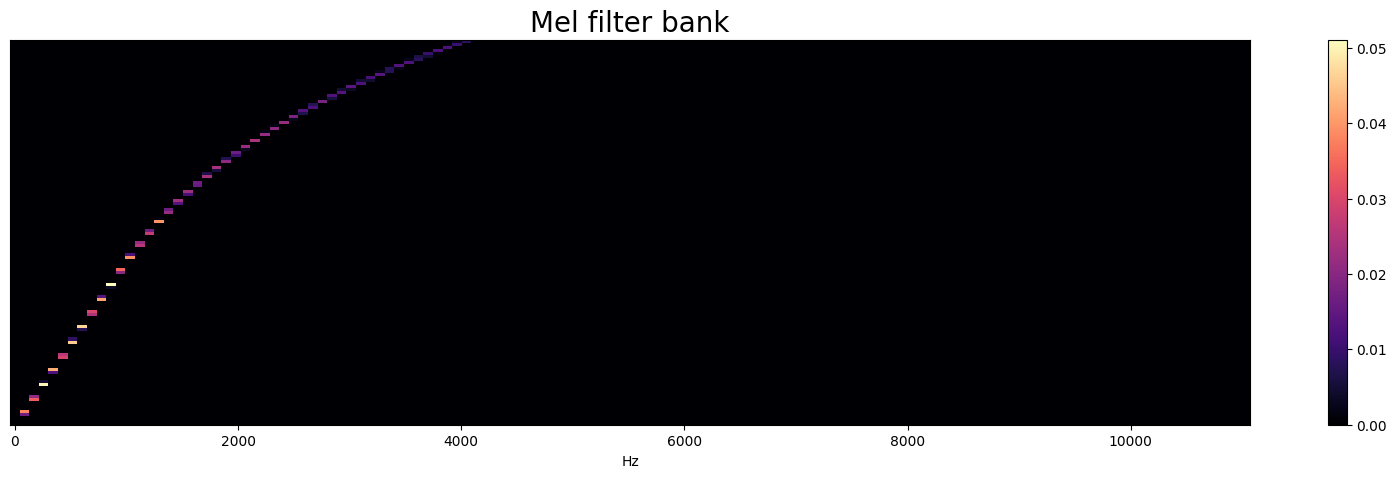

In [20]:
fmax_dataset = 4096
mel_basis = librosa.filters.mel(sr=sr_agent, n_fft=256, n_mels=128, fmax=fmax_dataset)

plt.figure(figsize=(20,5))
librosa.display.specshow(mel_basis, x_axis='linear',fmax=fmax_dataset)
plt.title('Mel filter bank', fontsize=20)
plt.colorbar()
plt.show()

We will use this helper function to visualize your merged audio file. Note the keywords used below. First we will set the max frequency considered for our mel scale (`fmax`) to the max possible frequency for this sampling rate (Nyquist Frequency, `sample_rate/2`). The number of bins is effectively the "resolution" in mel scale of the vertical axis.

In [21]:
# helper function to plot a mel spectrogram
# arguments: (wave array, sampling rate, number of mel bins, max frequency of mel scale)
def plot_melspectrogram(wav, sr, annotations=None, n_mels=256, fmax=4096,
                        fig=None, ax=None, show_legend=True):

    if ax == None:
      fig, ax = plt.subplots(1,1,figsize=(20,5))
    M = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax, fmax=fmax)
    if show_legend:
      ax.set(title='Mel spectrogram display')
      fig.colorbar(img, ax=ax, format="%+2.f dB")

    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x,y,text in annotations:
            ax.annotate(
            text,
            xy=(x,y), xycoords='data',
            xytext=(10, -50), textcoords='offset pixels',
            horizontalalignment='right',
            color='white',
            fontsize=20,
            verticalalignment='bottom',
            arrowprops=dict(
                arrowstyle= '-|>',
                 color='white',
                 lw=1,
                 ls='-')
            )

Now we can use the helper function to visualize a Mel spectrogram of the combined audio file you created

ValueError: ignored

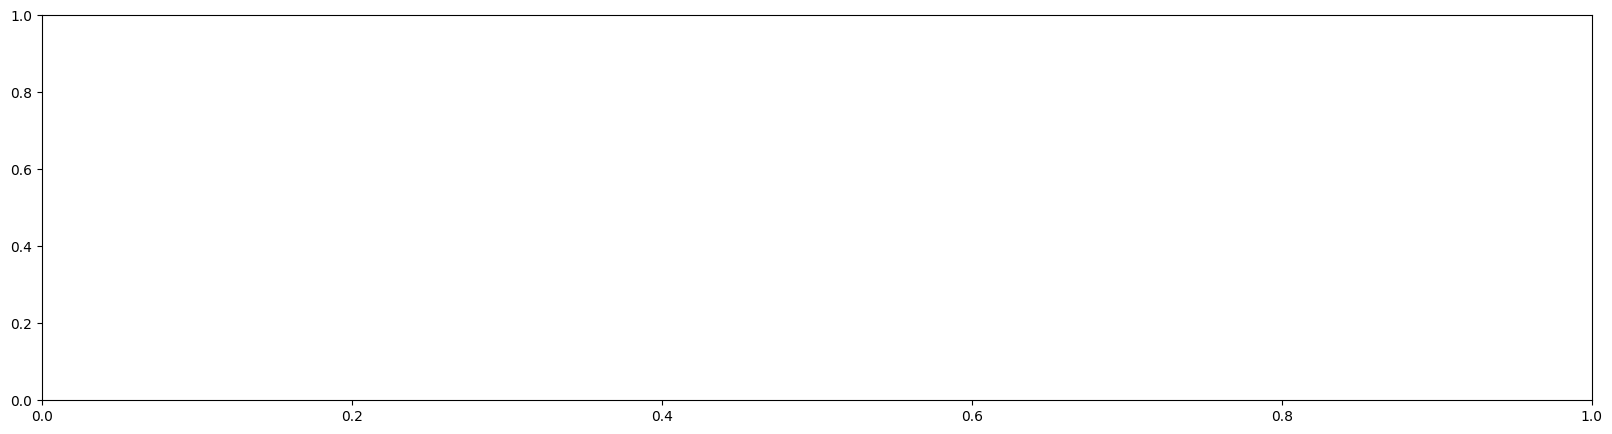

In [22]:
plot_melspectrogram(wav_total, sr_agent, annotations=None, n_mels=256, fmax=sr_agent/2)

Notice there is no energy above 4kHz. The dataset was collected using telephone speech, which has a sampling rate of 8kHz. Therefore the highest meaningful frequency in these recordings is 4kHz. Use the plotting arguments below as your default when displaying audio to hand in. For convenience we also set these as the default for the helper function.

ValueError: ignored

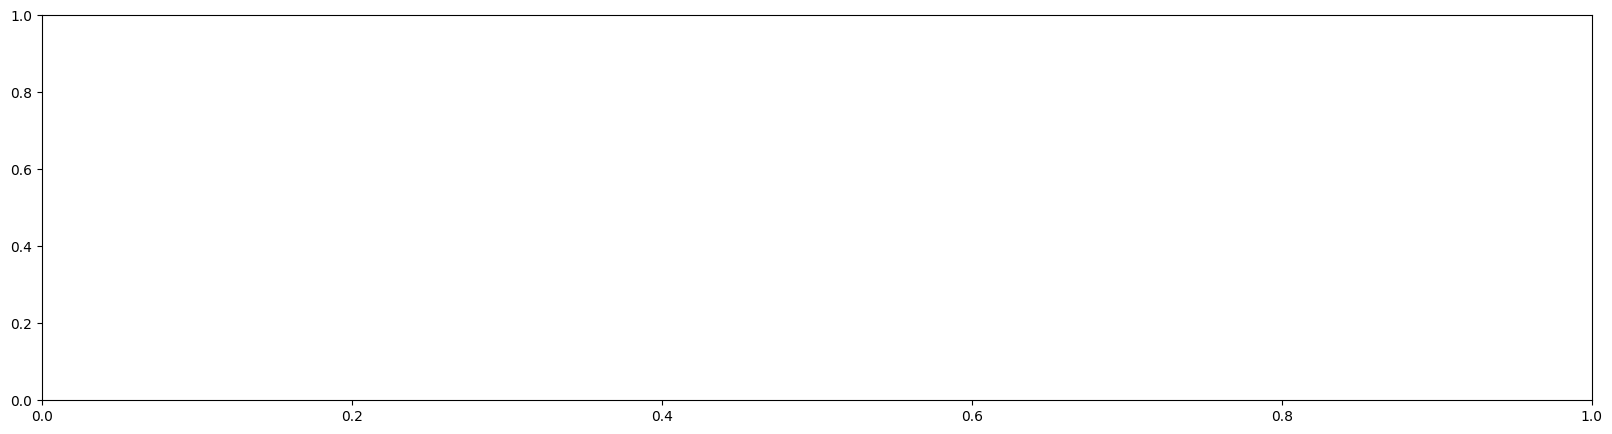

In [23]:
# we can adjust the keyword arguments
fmax_dataset = 4096
plot_melspectrogram(wav_total, sr_agent, annotations=None, n_mels=256, fmax=fmax_dataset)
plot_melspectrogram(wav_total, sr_agent)

## **Task: Silence removal** (4 points)

We often analyze utterances from a single speaker at a time, rather than the conversation. We also want to focus on the actual _speech_ audio rather than long silences / pauses between utterances.

Focusing on the **agent**, your task is to remove most of the major silences from the raw waveform file. This will collapse all of the agent's utterances into a single array with just short pauses between utterances. Removing silences in this way helps focus on the speech parts of an audio file. Sometimes this process is called _voice activity detection_ (and is more dificult in scenarios with strong background noise or distortion when speech can be hard to identify from the background).

One way to do this:

1. Use `librosa.effects.split` to split the agent .wav file by silence.
2. Clip out the silences and combine the audio back into a single array with silences removed. Ensure you aren't filtering too aggressively and clipping out actual audio.

You are free to try other approaches to silence removal. It should sound like a more or less continuous utterance stream from the speaker, but it need not be perfect. Describe your approach briefly along with the implementation.

In [ ]:
recon_agent = None # TODO: create a NumPy array with silences removed

#############################
#### YOUR CODE GOES HERE ####

#############################

In [ ]:
# listen to your audio file
ipd.Audio(recon_agent, rate=sr_agent)

In [ ]:
# This should now have minimal gaps between utterances
# (leaving some small silences is okay)
plot_melspectrogram(recon_agent, sr_agent)

## **Task: Segment a single utterance** (2 points)

Finally, an entire audio signal is too long, so let's pick a few utterances for further work.

**HW Task (5 points)**: In the conversation above, the agent says the following: `This is Harper Valley National Bank. My name is Elizabeth. How can I help you today?`. Slice a single wave array for just this part of the utterance and visualize the corresponding spectrogram.

In [ ]:
audio_signal = None # TODO: represent as a NumPy array

#############################
#### YOUR CODE GOES HERE ####

#############################

In [ ]:
# listen to your audio file
ipd.Audio(audio_signal, rate=sr_agent)

In [ ]:
plot_melspectrogram(audio_signal, sr_agent)

## **Task: Label words in the spectrogram** (5 points)

We know the true _transcript_ for this utterance, but it's also important to build an understanding of how words and phonemes appear in a spectrogram representation. This assists when debugging spoken language systems, and especially when building text to speech engines.

Using the helper function we created, you can add text labels to the spectrogram plot. Here is a single annotation to demonstrate the format:

In [ ]:
utt_words = [(0.1, 1024, 'This'),]
plot_melspectrogram(audio_signal, sr_agent, annotations=utt_words)

Your task is to label all remaining words in the utterance. Try to position each annotation at the center of each word in time (x axis). You may place the word anywhere along the frequency axis for readability. We won't check the time positions of your labels precisely, just point to each word without words overlapping when displayed.

Position text anywhere along the frequency (y) axis to avoid text overlap, there is no "correct" answer on where to position words along this axis, only the time axis.

In [ ]:
# TODO: Position the remaining words correctly using the same format:
#  (time (s), frequency(Hz), annotation(string))
utt_words = [(0.1, 1024, 'This'),]
#############################
#### YOUR CODE GOES HERE ####

#############################

In [ ]:
plot_melspectrogram(audio_signal, sr_agent, annotations=utt_words)

## **Task: Visually estimate mean F_0** (1 point)

F_0 is the fundamental frequency of a speaker (corresponding to the lowest harmonic of the speaker's glottal pulse train). On a Mel spectrogram, F_0 appears as the lowest frequency "line" of high energy in _voiced_ regions of speech (when the glottis is producing sound)

Visually estimate the mean F_0 frequency during the word national. Does the F_0 curve have high variance during this word? (it's okay if your F_0 estimate isn't exact.)

In [ ]:
#############################
#### YOUR CODE/ANSWER GOES HERE ####

#############################

# Visualizing alternative audio representations

We've been visualizing our utterances in Mel Spectrograms because it is easier to "read" speech-relevant phones in this view. Now let's look at the raw waveform time series plot itself. We will use the same `audio_signal` waveform in all the exercises below.

In [ ]:
def show_waveplot(audio_signal,sr,annotations=None):
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    librosa.display.waveplot(audio_signal, sr=sr)
    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x,y,text in annotations:

            ax.annotate(
            text,
            xy=(x,y), xycoords='data',
            xytext=(10, -50), textcoords='offset pixels',
            horizontalalignment='right',
            color='black',
            fontsize=20,
            verticalalignment='bottom',
            arrowprops=dict(
                arrowstyle= '-|>',
                 color='black',
                 lw=1,
                 ls='-')
            )

In [ ]:
show_waveplot(audio_signal,sr_agent)

## **Task: Label words in the time domain plot** (2 points)

Populate word-level annotations for the time domain plot. You should be able to use the same time annotations from the spectrogram plot. However you will need to adjust the y axis positions for words (again precise positions on the vertical axis are not graded, just try to prevent overlapping words)

In [ ]:
#  (time (s), amplitude, annotation(string))
utt_words = [(0.1, 0, 'This'),]
#############################
#### YOUR CODE GOES HERE ####

#############################

In [ ]:
show_waveplot(audio_signal,sr_agent,utt_words)

Answer a few followup questions in text below:
1. Describe what aspects of speech you can infer in this time series plot compared to the Mel spectrum above. Compare the two, when might looking at one vs the other help when working with audio data?
2. Does each word have a distinct segment in the time-amplitude plot? (A segment in this context is portion of the waveform clearly larger than 0)
3. Specify a word that has more than one distinct segment in the time-amplitude plot.

(Your answers here)
1.
2.
3.

## Mel frequency cepstral coefficients (MFCCs)

MFCCs are a prominent feature choice for speech recognition and related tasks, especially when using Gaussian Mixture Models (GMMs) for acoustic modeling (we will cover this in our speech recognition section).

While less popular for modern speech processing with neural networks, they are commonly used with more traditional statistical methods and you will likely encounter this feature representation when working with different speech tools.

A [cepstrum](https://en.wikipedia.org/wiki/Cepstrum) is a spectrum of a spectrum (e.g. nested fourier transform). MFCCs are a cepstral representation of the Mel spectrum. Usually, to compute MFCCs, you first do a fourier transform on the audio waveform, map to the Mel scale, followed by a second transform.

MFCCs are a popular choice in speech modeling because they produce approximately independent feature dimensions. This allows us to simplify acoustic modeling assumptions by assuming a diagonal covariance matrix for MFCCs (rather than modeling the full covariance structure of the features).

### **Task: Compute MFCC features** (3 points)

Use `librosa.feature` to compute and plot the MFCC for the `audio_signal` waveform. Use a `hop_length` of 512 and 32 cepstral coefficients. Once you compute the MFCCs we provide code to plot the MFCCs, and then _invert_ the MFCC transform to view the MFCCs as a Mel spectrogram again. Once you have this working, describe what differences you observe between the original log Mel spectrogram and the one recovered from your MFCC features.

In [ ]:
mfcc_feats = None #TODO fill this in
# start with these Mel spectrograms so MFCC computes only the final transform
# alternatively you can compute MFCCs from the orignal waveform but ensure you pass
#   arguments to .mfcc() to match our Mel Spectrogram processing above
mel_feats = librosa.feature.melspectrogram(y=audio_signal, sr=sr_agent,
                                           n_mels=256, fmax=4096, n_fft=2048)
log_mel_feats = librosa.power_to_db(mel_feats, ref=np.max)

#############################
#### YOUR CODE GOES HERE ####

#############################

# This will display your MFCCs. We do not expect this to be a meaningful visual
# We only use this plot to check your MFCC values while grading
librosa.display.specshow(mfcc_feats, x_axis='time')

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(20,8))
librosa.display.specshow(log_mel_feats,
                         x_axis='time', y_axis='mel', fmax=4096, ax=ax[0])
ax[0].set_title('Original Mel Spectrogram')

# this inverts the MFCC transform, takes the log of the Mel spectrum, and plots
librosa.display.specshow(librosa.power_to_db(librosa.feature.inverse.mfcc_to_mel(mfcc),
                                             ref=np.max),
                         x_axis='time', y_axis='mel', fmax=4096, ax=ax[1])
ax[1].set_title('Inverted MFCC Spectrogram')
plt.show()


Describe what differences you observe between the original Mel spectrogram and the spectrogram recovered from inverting the MFCC feature transform.

(Your answer here)

# Pitch estimation and warping

Earlier we roughly estimated F_0 by visually inspecting the spectrogram. There are a range of algorithms to robustly, automatically extract the _pitch track_ of an utterance. Here is an example of F_0 extraction using the [SWIPE](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.324.4466&rep=rep1&type=pdf) algorithm.

In [ ]:
# our calls are loaded with a sampling rate of 22kHz.
# 1024 hop size means we compute a pitch estimate approxiately every .046 seconds
pitch_hop = 1024
voicing_threshold = 0.3
f0_swipe = pysptk.swipe(audio_signal, fs=sr_agent, hopsize=pitch_hop,
                        min=60, max=512, otype="f0", threshold=voicing_threshold)

In [ ]:
time_labels = (pitch_hop / sr_agent) * np.arange(len(f0_swipe))

fig, ax = plt.subplots(3,1,figsize=(20,5))
ax[0].plot(time_labels, f0_swipe, 'k.')
ax[0].set_xlim([0, time_labels[-1]])
ax[0].set_xticks(np.arange(6.0, step=0.5))

plot_melspectrogram(audio_signal, sr_agent, annotations=None, n_mels=256,
                    fmax=4096, fig=fig, ax=ax[1], show_legend=False)
librosa.display.waveplot(audio_signal, sr=sr_agent, ax=ax[2])

## **Task: Try pitch extraction variations to improve** (10 points)

The SWIPE algorithm and parameters provided are a reasonable starting point for F_0 estimation, but not a state-of-the-art approach. Pitch estimation algorithms are often sensitive to background noise and recording conditions.

Try at least two alternative settings for the SWIPE extractor, or go further and experiment with a different pitch estimation algorithm.
1. Overlay your different estimates on the same plot
2. Describe what differences you observe
3. Explain which extractor best matches what you think is the "correct" pitch estimate for this audio and why.

Some hints:
- SWIPE can be sensitive to the choice of `voicing_threshold` which is how it separates unvoiced spoken regions (e.g. the phoneme "sh") from voiced regions
- In our example, we specify `otype=f0` to make SWIPE estimate F0. Try estimating pitch or log_f0. Remember: _pitch_ is human perception of F0 whereas F0 is the measured value of fundamental frequency.
- The `pysptk` toolkit also provides the REAPER pitch estimator you can try

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

## Pitch warping

One thing we often do with speech data is shift pitches. This could be used as data augmentation technique (e.g. to prevent overfitting when training neural networks) or as standardization technique to obscure speaker identity (e.g. for privacy purposes, or to make a system more robust to many different speakers).

In [ ]:
# recall our original snippet
ipd.Audio(audio_signal, rate=sr_agent)

We can use the `librosa.effects` library to shift our sample up and down. See the examples below and listen to the shifted samples.

In [ ]:
# shift up by four half steps
audio_u4hs = librosa.effects.pitch_shift(audio_signal, sr_agent, n_steps=4)
ipd.Audio(audio_u4hs, rate=sr_agent)

In [ ]:
# shift down by six half steps
audio_d6hs = librosa.effects.pitch_shift(audio_signal, sr_agent, n_steps=-6)
ipd.Audio(audio_d6hs, rate=sr_agent)

### **Task: Extract and plot F0 for pitch-shifted examples** (5 points)

Using the pitch extraction routine you refined above, plot the extracted F0 or pitch for the original, up-shifted, and down-shifted utterances.

Describe how the extracted pitch estimates change, and any adjustments you needed to make to your pitch extraction settings.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

### **Task: Match agent and caller voices** (10 points)

Using pitch shifting, and any other effects you choose, try to make the agent and caller sound as if they are the same person speaking. Recombine both clips into a single waveform and use `ipd.Audio` to listen to your results.

If you're successful, it should sound like just one speaker is performing both sides of the conversation. As a baseline, it's fine to simply try to make both speakers' mean F_0 approximately equal. Try to ensure you can still understand the utterances as you work to make the speakers sound similar.

Plot the extracted pitch and Mel spectrogram for both speakers before and after your transformation

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

# Synthesizing from Mel spectral envelopes

Finally, let's use re-synthesis to have some fun! Re-synthesis is a great way to establish a baseline when building text to speech (TTS) systems, or other audio transforms. Essentially we convert audio into some (lossy) representation, and then attempt to recover the original audio by transforming it back. This can help set expectations for TTS development because it helps us debug which parts of our signal processing might impose limits on naturalness of the produced audio.

Here is a helper function to transform audio to mel cepstrum then re-synthesize a wave. You do not need to understand all steps here. pysptk uses low-level signal processing routines we won't cover in detail. More on this in our TTS lectures!

In [ ]:
# arguments: (wave array, sampling rate, number of mel bins, max frequency of mel scale)
def resynth_audio(wav, sr_orig, sr_tosynth=8192):
  order = 25
  alpha = 0.41
  frame_length = 512
  hop_length = 40

  # resample audio signal to 8kHz for easier work with pysptk synth tools
  # pysptk does not set a max frequency when computing the mel cepstrum features
  # thus it's easier to resample the audio so that sample_rate = 2*max_frequency
  signal_to_synth = librosa.resample(wav,sr_orig, sr_tosynth)

  # frames used in computing MFCCs in pysptk
  frames = librosa.util.frame(signal_to_synth, frame_length=frame_length,
                              hop_length=hop_length).astype(np.float64).T
  # Windowing
  frames *= pysptk.blackman(frame_length)

  mc = pysptk.mcep(frames, order, alpha, etype=1, eps=1e-8)
  logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real

  librosa.display.specshow(logH.T, sr=sr_tosynth, hop_length=hop_length, x_axis="time", y_axis="linear")
  plt.colorbar()
  plt.show()

  # Convert mel-cesptrum (MFCC) to MLSADF coefficients
  b = pysptk.mc2b(mc, alpha)

  # extract pitch
  pitch = pysptk.swipe(signal_to_synth.astype(np.float64), fs=sr_tosynth,
                       hopsize=hop_length, min=60, max=300, otype="pitch")
  source_excitation = pysptk.excite(pitch, hop_length)

  synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

  x_synthesized = synthesizer.synthesis(source_excitation, b)
  return x_synthesized

Helper function to record your own audio. You'll need to grant microphone access in your browser and have a working microphone for this to work

In [ ]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(ipd.Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

Here is an example of resynthesizing our test utterance.

In [ ]:
synth_sr = 8192
synth_wav = resynth_audio(audio_signal, sr_agent, synth_sr)

ipd.Audio(synth_wav, rate=synth_sr)

## **Task: Record yourself and resynthesize your utterance!** (5 points)

In [ ]:
# record yourself speaking!
# If this fails you can record using a system utility and upload the .wav file
record(5)

In [ ]:
# Play your audio file to verify it worked
ipd.Audio('./recorded_audio.wav')

In [ ]:
# it's okay to see a warning about PySoundFile here.
# It's due to the saved format of the recorded wav file
wav_mine, sr_mine = librosa.load('recorded_audio.wav')

In [ ]:
synth_sr = 16000
synth_wav = resynth_audio(wav_mine, sr_mine, synth_sr)

ipd.Audio(synth_wav, rate=synth_sr)

( Describe what differences you notice between your original audio and the re-synthesized audio. If you can't get recording your voice to work, you may describe differences for the agent utterance above. )

---

# Questions?

Please post on the Ed forum or come to office hours!